In [1]:
# for r in np.arange(1000,21000,1000):
#     MAX_NB_WORDS = r
#     # prepare embedding matrix
#     num_words = min(MAX_NB_WORDS, len(word_index))
#     embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
#     for word, i in word_index.items():
#         if i >= MAX_NB_WORDS:
#             continue
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             # words not found in embedding index will be all-zeros.
#             embedding_matrix[i] = embedding_vector

#     # load pre-trained word embeddings into an Embedding layer
#     # note that we set trainable = False so as to keep the embeddings fixed
#     embedding_layer = Embedding(num_words,
#                                 EMBEDDING_DIM,
#                                 weights=[embedding_matrix],
#                                 input_length=MAX_SEQUENCE_LENGTH,
#                                 trainable=False)
#     b = np.sum(np.argmax(embedding_matrix, axis=1) == 0)

#     print("{} words excluded from [{}x100] embedding matrix:{:.2f}%".format(b, r, (b/r)*100))
#     print()

In [2]:
from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0, beta=1):

   # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

   # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

Using TensorFlow backend.


In [3]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classication of newsgroup messages into 20 different categories).

GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function
%matplotlib inline
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard

BASE_DIR = '/home/adamszabunio'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
MAX_SEQUENCE_LENGTH = 80
MAX_NB_WORDS = 11000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [4]:
wine_df = pd.read_csv('winemag_data_first150k.csv')

clean_wine_df = wine_df.drop_duplicates(subset='description', keep='last')

In [5]:
X = clean_wine_df.description
y = pd.get_dummies(clean_wine_df.variety)

X.shape, y.shape

((97821,), (97821, 632))

In [6]:
# second, prepare text samples and their labels

texts = [descript for descript in X]  # list of text samples

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 97821 texts.
Found 37142 unique tokens.


In [7]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

labels = np.asarray(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=.1, random_state=42)

Shape of data tensor: (97821, 80)
Shape of label tensor: (97821, 632)


In [8]:
data[0]

array([   6, 1690,  400,  415,    8, 3019,   24, 2601,    1,  333,  306,
        119,  598,   64,   10,   40,  105,   38,   22,   13,    1,    3,
       1154,  172,    4,  294, 3197,    2,   23,  810,   30,  139,  102,
         21,    1,    3,  367,  603, 1287,   10,    2,  697,   86,    1,
       2253,   24,  673,   12,   18,   11,   26,   64, 1804,    4,   11,
         12,  384,  961, 1298,  538,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [9]:
print('Preparing embedding matrix.')
# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


In [10]:
print('Building model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(y.shape[1], activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', fbeta, precision, recall])

model.summary()

Building model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 100)           1100000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 128)           64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0    

In [11]:
tb_callback = TensorBoard(log_dir='./gloVe2pool')

In [12]:
hist = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_split=0.2,    
          callbacks=[tb_callback])

Train on 70430 samples, validate on 17608 samples
Epoch 1/10
70430/70430 [==============================] - 11s - loss: 3.4462 - acc: 0.2241 - fbeta: 0.1110 - precision: 0.5942 - recall: 0.0637 - val_loss: 3.1273 - val_acc: 0.2854 - val_fbeta: 0.2199 - val_precision: 0.7449 - val_recall: 0.1297
Epoch 2/10
70430/70430 [==============================] - 9s - loss: 2.6114 - acc: 0.3918 - fbeta: 0.3391 - precision: 0.8337 - recall: 0.2147 - val_loss: 2.4741 - val_acc: 0.4252 - val_fbeta: 0.3753 - val_precision: 0.8688 - val_recall: 0.2402
Epoch 3/10
70430/70430 [==============================] - 9s - loss: 2.2546 - acc: 0.4726 - fbeta: 0.4327 - precision: 0.8594 - recall: 0.2911 - val_loss: 2.2632 - val_acc: 0.4693 - val_fbeta: 0.4397 - val_precision: 0.8257 - val_recall: 0.3008
Epoch 4/10
70430/70430 [==============================] - 9s - loss: 2.0521 - acc: 0.5155 - fbeta: 0.4917 - precision: 0.8585 - recall: 0.3461 - val_loss: 2.2263 - val_acc: 0.4980 - val_fbeta: 0.4763 - val_precisio

In [13]:
score = model.evaluate(x_val, y_val, batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test fbeta:', score[2])
print('Test Precision:', score[3])
print('Test Recall:', score[4])

9783/9783 [==============================] - 0s     
Test loss: 2.38273007524
Test accuracy: 0.506593069464
Test fbeta: 0.517545945316
Test Precision: 0.758747191191
Test Recall: 0.393539814039


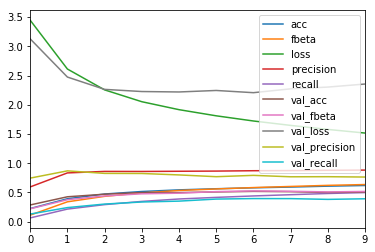

In [14]:
pd.DataFrame(hist.history).plot();

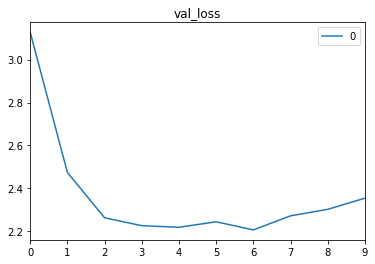

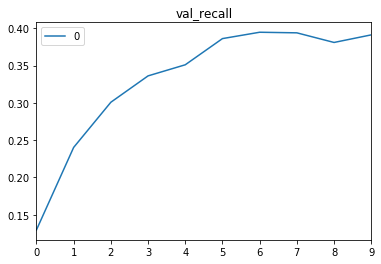

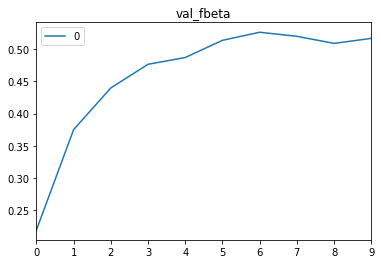

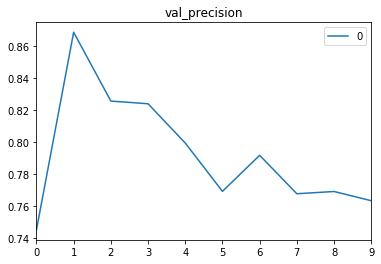

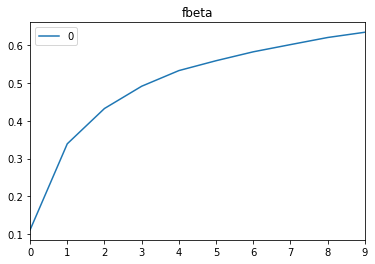

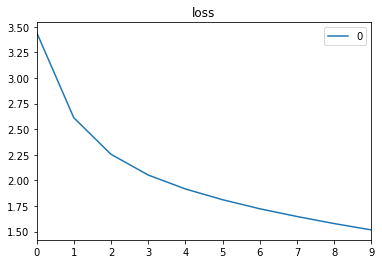

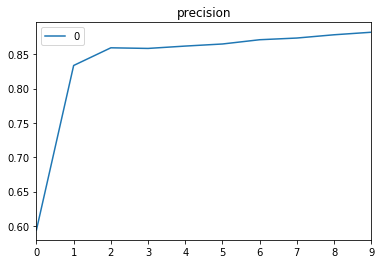

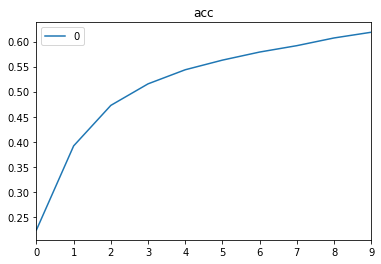

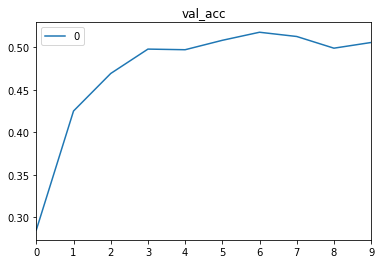

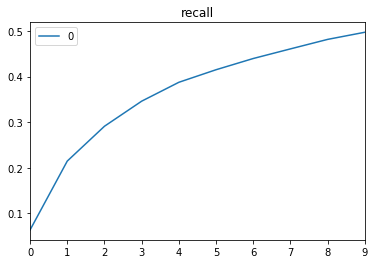

In [15]:
a = [k for k,v in hist.history.items()]
for ky in a:
    pd.DataFrame(hist.history[ky]).plot(title=ky);